# Solving the Van der Pol oscillator with the DeepXDE Framework
Raihaan Usman, UROP Student

DeepXDE is a data-driven framework developed by researchers at Brown University.

In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

Using backend: tensorflow.compat.v1

2022-07-28 12:42:46.648248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-28 12:42:46.648282: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2022-07-28 12:43:02.714512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-28 12:43:02.714555: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-28 12:43:02.714578: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-baf76a): /proc/driver/nvidia/version does not exist


### Van der Pol Solver

Compiling model...
Building feed-forward neural network...
'build' took 0.048829 s

'compile' took 0.565800 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.25e+00, 1.25e-01, 6.95e-03]    [1.25e+00, 1.25e-01, 6.95e-03]    []  
1000      [2.52e-02, 9.17e-03, 1.19e-06]    [2.52e-02, 9.17e-03, 1.19e-06]    []  
2000      [1.86e-02, 6.13e-03, 2.46e-04]    [1.83e-02, 6.13e-03, 2.46e-04]    []  
3000      [2.67e-05, 4.03e-08, 3.94e-06]    [1.89e-05, 4.03e-08, 3.94e-06]    []  
4000      [9.26e-05, 9.09e-07, 4.79e-09]    [9.19e-05, 9.09e-07, 4.79e-09]    []  
5000      [9.03e-06, 8.31e-10, 1.50e-07]    [7.35e-06, 8.31e-10, 1.50e-07]    []  
6000      [4.58e-04, 6.57e-07, 4.00e-08]    [4.63e-04, 6.57e-07, 4.00e-08]    []  
7000      [1.95e-04, 1.18e-06, 7.21e-09]    [1.96e-04, 1.18e-06, 7.21e-09]    []  
8000      [4.12e-04, 1.31e-05, 5.89e-07]    [4.21e-04, 1.31e-05, 5.89e-07]    []  
9000   

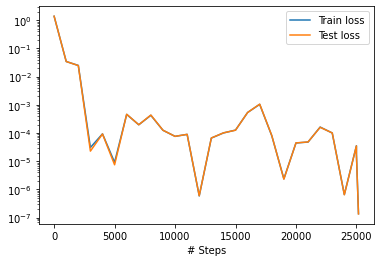

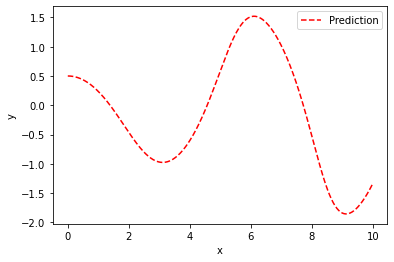

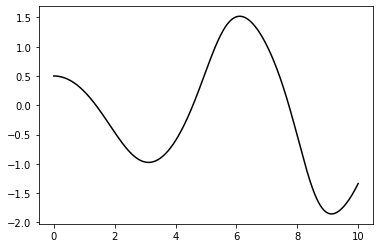

In [8]:
# PDE parameters
mu = 0.5
X0 = [0.5, 0]
tf = 10

# Hyperparameters
alpha           = 0.005
loss_weights    = [2, 0.5, 0.05]    # [X, x1(0), x2(0)] errors

# VdP oscillator
ODE         = lambda X, t:  np.array([X[1], mu*(1-X[0]**2)*X[1]-X[0]])
true_sol    = lambda t:     odeint(ODE, X0, t)

# The PDE problem
def VdP(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    d2y_dt2 = dde.grad.hessian(y, t)
    return  d2y_dt2 - mu * (1 - y ** 2) * dy_dt + y

# Time domain definition
geom = dde.geometry.TimeDomain(0, tf)


# Boundary return function - for Time Domain
def boundary_l(t, on_initial):
    return on_initial and np.isclose(t[0], 0)


''' Passive ICs are used! '''

# x1(0) = 0.5
def bc_func1(inputs, outputs, X):
    return outputs - 0.5

# x2(0) = 0
def bc_func2(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=None)


# ic1 = dde.icbc.IC(geom, lambda x: -1, lambda _, on_initial: on_initial)
ic1 = dde.icbc.OperatorBC(geom, bc_func1, boundary_l)
ic2 = dde.icbc.OperatorBC(geom, bc_func2, boundary_l)

# Define the PDE problem
data = dde.data.TimePDE(geom, VdP, [ic1, ic2], 200, 2, num_test=500)

# Solver architecture
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# Create a Model using the PDE and neural network definitions
model = dde.Model(data, net)

# Compile the model!
model.compile(
    "adam", lr=alpha, loss_weights=loss_weights     # Removed metrics=["l2 relative error"]
)
losshistory, train_state = model.train(iterations=25000)

# Recompile with new optimizer L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


t = np.linspace(0, tf, 500)
sol = true_sol(t)
x1, x2 = np.hsplit(true_sol(t), 2)

plt.plot(t, x1, color="black", label="x1")
